In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.saving import hdf5_format
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.utils import plot_model
import random
import h5py
from sklearn.metrics import classification_report

##################
# Verifications:
#################
print('GPU is used.' if len(tf.config.list_physical_devices('GPU')) > 0 else 'GPU is NOT used.')
print("Tensorflow version: " + tf.__version__)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

GPU is used.
Tensorflow version: 2.12.0


In [2]:
# Traning Images
data_url = "http://206.12.93.90:8080/simpson2022_dataset/scene_img_abstract_v002_train2015.tar.gz"
zip_path = keras.utils.get_file("scene_img_abstract_v002_train2015.tar.gz", data_url, extract=True)
imgs_path_train = os.path.dirname(zip_path) + '/scene_img_abstract_v002_train2015/'

#  Validation Images
data_url = "http://206.12.93.90:8080/simpson2022_dataset/simpsons_validation.tar.gz"
zip_path = keras.utils.get_file("simpsons_validation.tar.gz", data_url, extract=True)
imgs_path_val = os.path.dirname(zip_path) + '/simpsons_validation/'

# Traning Questions
data_url = "http://206.12.93.90:8080/simpson2022_dataset/OpenEnded_abstract_v002_train2015_questions.zip"
zip_path = keras.utils.get_file("OpenEnded_abstract_v002_train2015_questions.zip", data_url,
                                cache_subdir='datasets/OpenEnded_abstract_v002_train2015_questions/', extract=True)
q_train_file = os.path.dirname(zip_path) + '/OpenEnded_abstract_v002_train2015_questions.json'

#  Validation Questions
data_url = "http://206.12.93.90:8080/simpson2022_dataset/questions_validation.zip"
zip_path = keras.utils.get_file("questions_validation.zip", data_url,
                                cache_subdir='datasets/questions_validation/', extract=True)
q_val_file = os.path.dirname(zip_path) + '/questions_validation.json'

# Traning Annotations
data_url = "http://206.12.93.90:8080/simpson2022_dataset/abstract_v002_train2015_annotations.zip"
zip_path = keras.utils.get_file("abstract_v002_train2015_annotations.zip", data_url,
                                cache_subdir='datasets/abstract_v002_train2015_annotations/', extract=True)
anno_train_file = os.path.dirname(zip_path) + '/abstract_v002_train2015_annotations.json'

# Validation Annotations
data_url = "http://206.12.93.90:8080/simpson2022_dataset/annotations_validation.zip"
zip_path = keras.utils.get_file("annotations_validation.zip", data_url,
                                cache_subdir='datasets/annotations_validation/', extract=True)
anno_val_file = os.path.dirname(zip_path) + '/annotations_validation.json'

2967/2967 [==============================] - 0s 0us/step


In [3]:
# We define the size of input images to 64x64 pixels.
img_width = 256
img_height = 256
image_size = (img_height, img_width)


In [4]:
answers = ['yes', 'no']
num_answers = len(answers)

In [5]:
# Read the data files
q_train = json.load(open(q_train_file))
q_val = json.load(open(q_val_file))
anno_train = json.load(open(anno_train_file))
anno_val = json.load(open(anno_val_file))

'''
    Filter questions for which the answers are not in the set of possible answers.
'''


def filter_questions(questions, annotations, answers, imgs_path):
    # Make sure the questions and annotations are alligned
    questions['questions'] = sorted(questions['questions'], key=lambda x: x['question_id'])
    annotations['annotations'] = sorted(annotations['annotations'], key=lambda x: x['question_id'])
    q_out = []
    anno_out = []
    imgs_out = []
    q_ids = []
    question_ids_set = set()
    # Filter annotations
    for annotation in annotations['annotations']:
        if annotation['multiple_choice_answer'] in answers:
            question_ids_set.add(annotation['question_id'])
            q_ids.append(annotation['question_id'])
            anno_out.append(answers.index(annotation['multiple_choice_answer']))
    # Filter images and questions
    for q in questions['questions']:
        if q['question_id'] in question_ids_set:
            # Preprocessing the question
            q_text = q['question'].lower()
            q_text = q_text.replace('?', ' ? ')
            q_text = q_text.replace('.', ' . ')
            q_text = q_text.replace(',', ' . ')
            q_text = q_text.replace('!', ' . ').strip()
            q_out.append(q_text)
            file_name = str(q['image_id'])
            while len(file_name) != 12:
                file_name = '0' + file_name
            file_name = imgs_path + questions['data_type'] + '_' + questions['data_subtype'] + '_' + file_name + '.png'
            imgs_out.append(file_name)
    return imgs_out, q_out, anno_out, q_ids


imgs_train, q_train, anno_train, q_ids_train = filter_questions(q_train, anno_train,
                                                                answers, imgs_path_train)
imgs_train, q_train, anno_train, q_ids_train = shuffle(imgs_train, q_train,
                                                       anno_train, q_ids_train, random_state=0)

imgs_val, q_val, anno_val, q_ids_val = filter_questions(q_val, anno_val,
                                                        answers, imgs_path_val)
imgs_val, q_val, anno_val, q_ids_val = shuffle(imgs_val, q_val,
                                               anno_val, q_ids_val, random_state=0)

In [6]:
# Get the vocabulary
vocab_size = 15000
vocab = {}
for q in q_train:
    q = q.split(' ')
    for token in q:
        v = vocab.get(token, 0)
        vocab[token] = v + 1
vocab = list(dict(sorted(vocab.items(), key=lambda x: -x[1])[0:vocab_size]).keys())
# Mapping tokens to integers
token_to_num = keras.layers.StringLookup(vocabulary=vocab)
# Mapping integers back to original tokens
num_to_token = keras.layers.StringLookup(vocabulary=token_to_num.get_vocabulary(),
                                         invert=True)
vocab_size = token_to_num.vocabulary_size()
print(f"The size of the vocabulary ={token_to_num.vocabulary_size()}")
print("Top 20 tokens in the vocabulary: ", token_to_num.get_vocabulary()[:20])

The size of the vocabulary =3830
Top 20 tokens in the vocabulary:  ['[UNK]', 'the', '?', 'is', 'a', 'are', 'on', 'there', 'in', 'to', 'man', 'woman', 'dog', 'girl', 'does', 'boy', 'of', 'this', 'cat', 'it']


In [7]:
'''
    This function is used to process and encode a single sample.
'''


def encode_single_sample(img_file, q, anno):
    ###########################################
    ##  Process the Image
    ##########################################
    # 1. Read image file  
    img = tf.io.read_file(img_file)
    # 2. Decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    ###########################################
    ##  Process the question
    ##########################################
    # 5. Split into list of tokens
    word_splits = tf.strings.split(q, sep=" ")
    # 6. Map tokens to indices
    q = token_to_num(word_splits)
    # 7. Return an inputs to for the model
    return (img, q), anno


In [8]:
# We define the batch size
batch_size = 128
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (imgs_train, q_train, anno_train)
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
        .padded_batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
)
# Define the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices(
    (imgs_val, q_val, anno_val)
)
val_dataset = (
    val_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
        .padded_batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
)


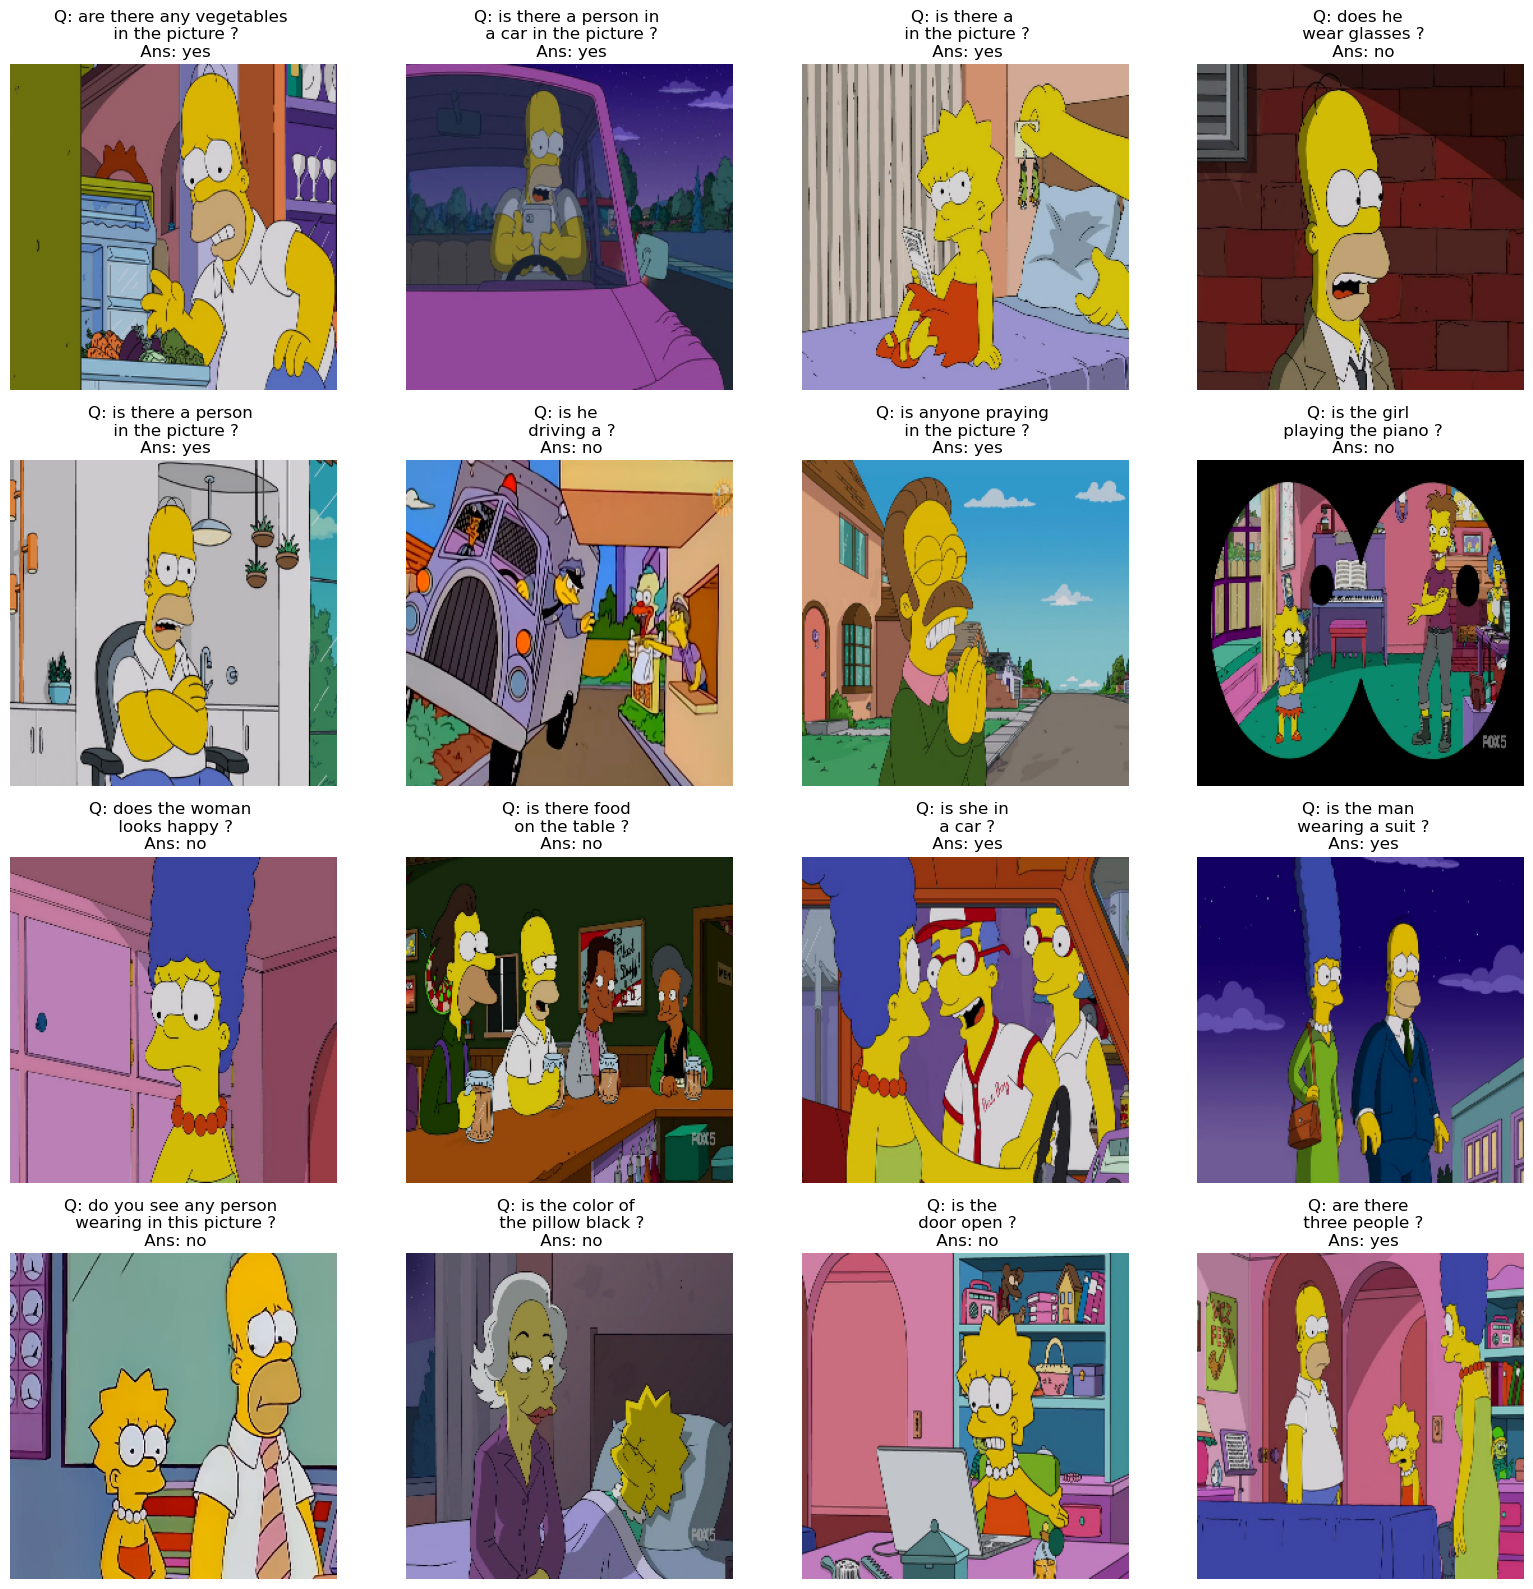

In [9]:
#  Let's check results on some validation samples
for batch in val_dataset.shuffle(random.randint(0, 200)).take(1):
    imgs_batch = batch[0][0]
    q_batch = batch[0][1]
    ans_batch = batch[1]
    answer_texts = [answers[i] for i in ans_batch]

    q_orig = []
    for q in q_batch:
        q = num_to_token(q).numpy()
        q = [t.decode("utf-8") for t in q]
        q = list(filter(('[UNK]').__ne__, q))
        q.insert(int(len(q) / 2), '\n')
        q = ' '.join(q)
        q_orig.append(q)

    _, ax = plt.subplots(4, 4, figsize=(16, 16))
    for i in range(16):
        img = (imgs_batch[i, :, :, :] * 255).numpy().astype(np.uint8)
        title = f"Q: {q_orig[i]}\n Ans: {answer_texts[i]}"
        ax[i // 4, i % 4].imshow(img)
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

    plt.tight_layout()
    plt.show()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 252, 252, 64  4864        ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 126, 126, 64  0          ['conv2d_7[0][0]']               
                                )                                                           

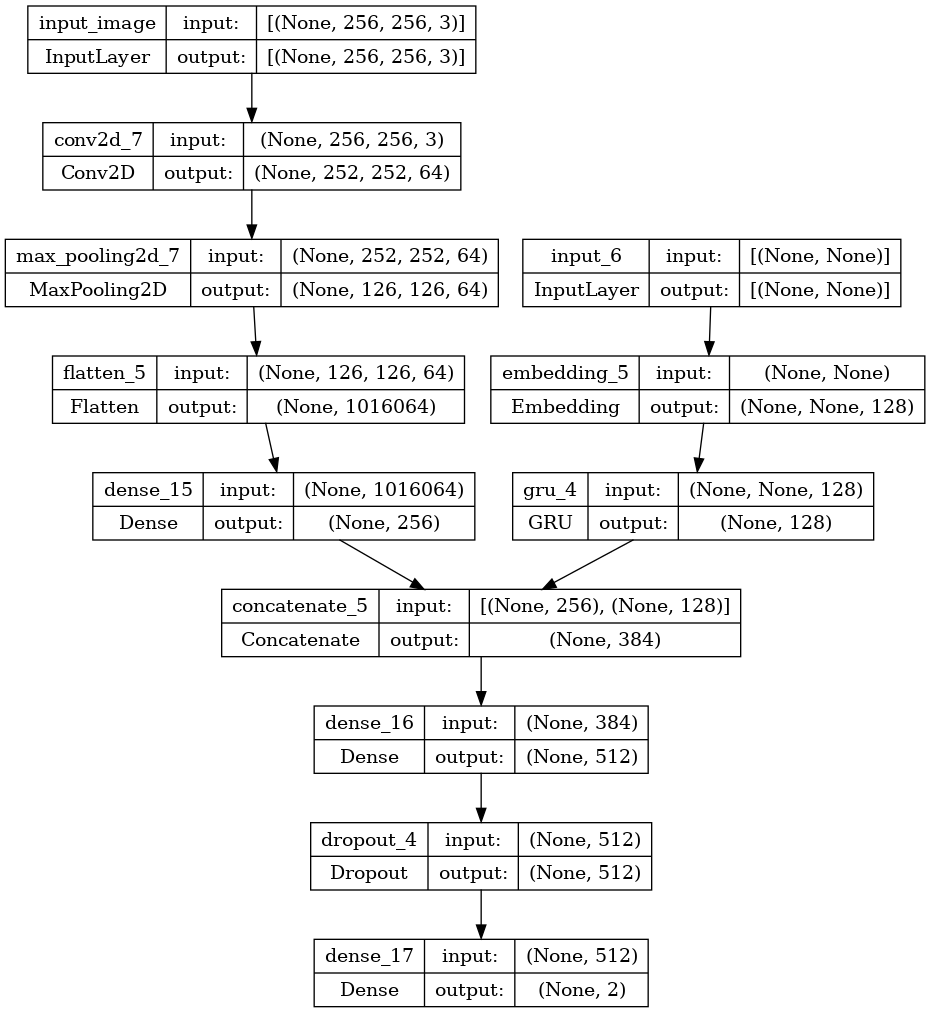

In [32]:
# This model is the deeper LSTM Q from Figure 8 in
# https://arxiv.org/pdf/10505.00468.pdf
def build_model(image_size, vocab_size, num_answers):
    # Define the VGG19 conv_base for image input
    # Image input
    image_input = layers.Input(shape=image_size + (3,), name="input_image")
    # Preprocessing the image
    image_model = layers.Conv2D(64, (5, 5), activation='relu')(image_input)
    image_model = layers.MaxPooling2D((2, 2))(image_model)
    image_model = layers.Flatten()(image_model)
    image_model = layers.Dense(256, activation='relu')(image_model)

    # Question input
    question_input = layers.Input(shape=(None,))
    # Embedding the question
    question_model = layers.Embedding(vocab_size, 128)(question_input)
    question_model = layers.GRU(128)(question_model)

    # Combining image and question features
    combined = layers.concatenate([image_model, question_model])
    combined = layers.Dense(512, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)
    output = layers.Dense(num_answers, activation='softmax')(combined)

    # Create the model
    model = tf.keras.Model(inputs=[image_input, question_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    return model


# Get the model
model = build_model(image_size, vocab_size, num_answers)
model.summary()
plot_model(model, show_shapes=True)

In [33]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
)


Epoch 1/10
192/192 [==============================] - 179s 902ms/step - loss: 1.7786 - accuracy: 0.5798 - val_loss: 0.7082 - val_accuracy: 0.5000
Epoch 2/10
192/192 [==============================] - 169s 876ms/step - loss: 0.6045 - accuracy: 0.6664 - val_loss: 0.8516 - val_accuracy: 0.5867
Epoch 3/10
192/192 [==============================] - 168s 875ms/step - loss: 0.4106 - accuracy: 0.8148 - val_loss: 1.0592 - val_accuracy: 0.6067
Epoch 4/10
192/192 [==============================] - 168s 873ms/step - loss: 0.2685 - accuracy: 0.8938 - val_loss: 1.2921 - val_accuracy: 0.5400
Epoch 5/10
192/192 [==============================] - 168s 877ms/step - loss: 0.1850 - accuracy: 0.9313 - val_loss: 1.4660 - val_accuracy: 0.5267
Epoch 6/10
 26/192 [===>..........................] - ETA: 2:22 - loss: 0.1349 - accuracy: 0.9495

KeyboardInterrupt: 

In [28]:
model.save('model.h5', overwrite=True, save_format='h5')
with h5py.File('model.h5', mode='a') as f:
    f.create_dataset('answers', data=answers)
    f.create_dataset('vocab', data=vocab)


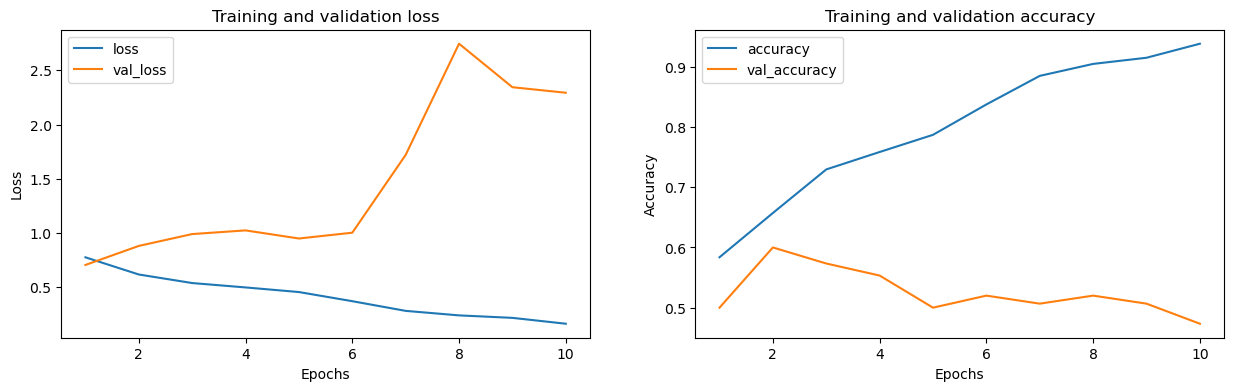

In [21]:
def learning_plots(history):
    plt.figure(figsize=(15, 4))
    ax1 = plt.subplot(1, 2, 1)
    for l in history.history:
        if l == 'loss' or l == 'val_loss':
            loss = history.history[l]
            plt.plot(range(1, len(loss) + 1), loss, label=l)

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    ax2 = plt.subplot(1, 2, 2)
    for k in history.history:
        if 'accuracy' in k:
            loss = history.history[k]
            plt.plot(range(1, len(loss) + 1), loss, label=k)
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


learning_plots(history)


In [22]:
y_prob = model.predict(val_dataset)
y_pred = y_prob.argmax(axis=-1)
print(classification_report(anno_val, y_pred, target_names=answers))


2/2 [==============================] - 2s 258ms/step
              precision    recall  f1-score   support

         yes       0.48      0.53      0.50        75
          no       0.47      0.41      0.44        75

    accuracy                           0.47       150
   macro avg       0.47      0.47      0.47       150
weighted avg       0.47      0.47      0.47       150



4/4 [==============================] - 1s 25ms/step


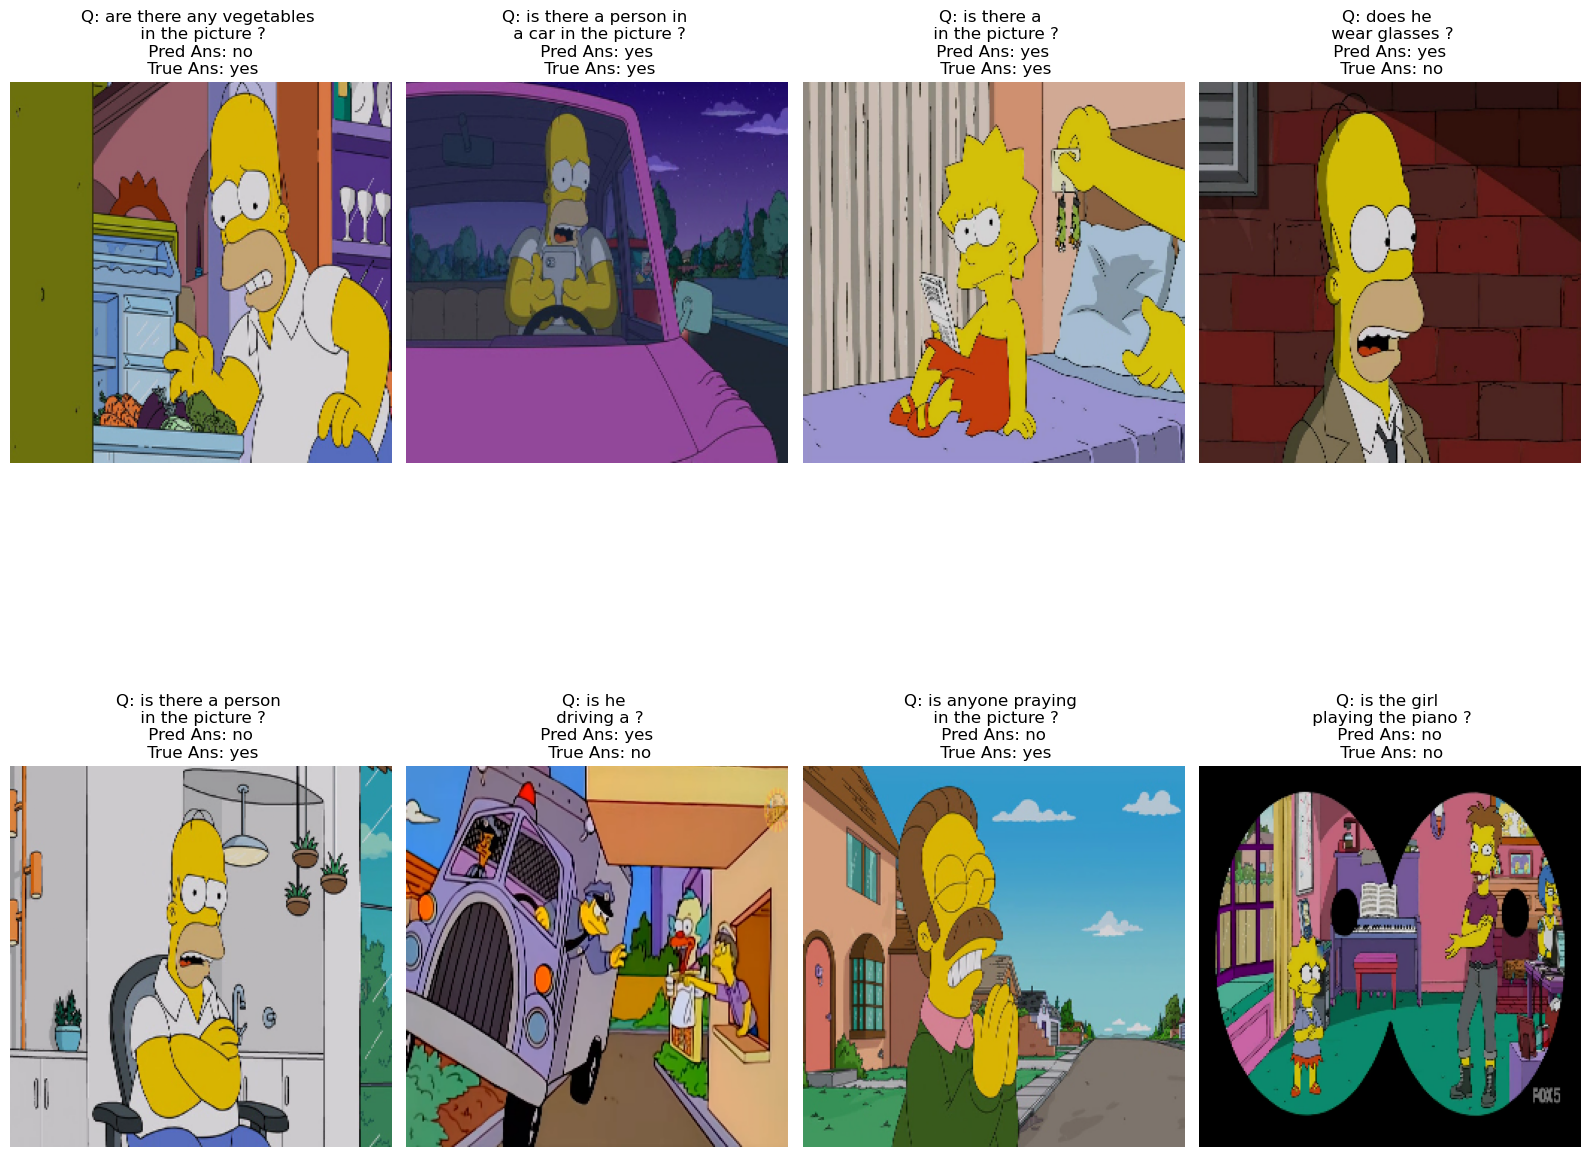

In [23]:
for batch in val_dataset.shuffle(20).take(1):
    imgs_batch = batch[0][0]
    q_batch = batch[0][1]
    ans_batch = batch[1]    
    answer_texts = [answers[i] for i in ans_batch]
    preds = model.predict(batch[0])
    pred_texts = [answers[i] for i in np.argmax(preds, axis=1)]
    q_orig = []
    for q in q_batch:
        q = num_to_token(q).numpy()
        q = [t.decode("utf-8") for t in q]
        q = list(filter(('[UNK]').__ne__, q))
        q.insert(int(len(q) / 2), '\n')
        q = ' '.join(q)
        q_orig.append(q)
    _, ax = plt.subplots(2, 4, figsize=(16, 16))
    for i in range(8):
        example_input = (np.array([imgs_batch[i]]), np.array([q_batch[i]]))
        title = f"Q: {q_orig[i]}\n Pred Ans: {pred_texts[i]} \n True Ans: {answer_texts[i]}"
        ax[i // 4, i % 4].imshow(imgs_batch[i])
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.tight_layout()
plt.show()

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of the ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation between -20 and 20 degrees
    width_shift_range=0.2,  # Randomly shift the width by 20% of the total width
    height_shift_range=0.2,  # Randomly shift the height by 20% of the total height
    shear_range=0.2,  # Shear transformation with a range of 20 degrees
    zoom_range=0.2,  # Random zoom between 80% and 120% of the original size
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in any newly created pixels using the nearest neighbor value
)

# Augment the data from train_dataset
train_generator = datagen.flow(
    x=train_dataset['images'],
    y=train_dataset['labels'],
    batch_size=32,
    shuffle=True
)

TypeError: '_PrefetchDataset' object is not subscriptable